In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel, DoG_Iso2DGaussianModel, Norm_Iso2DGaussianModel, CSenFModel
from prfpy.fit import Iso2DGaussianFitter
from prfpy.rf import gauss2D_iso_cart
import os
import yaml

from prfpy_bayes.utils import *
from prfpy_bayes.prf_bayes import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *
from scipy import stats 
import time

import multiprocessing
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/deep_prf/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# setup e.g. data and ts...
# Getting the correct stimuli
from amb_scripts.load_saved_info import *

sub = 'sub-02'
ses = 'ses-1'
task_list = ['CSFLE', 'CSFRE']# ['pRFLE', 'pRFRE'] 
model = 'csf'
roi_fit = 'V1_exvivo'

roi_mask = amb_load_roi(sub, roi_fit)
cprf_data = amb_load_prf_params(
    sub=sub,
    task_list=task_list,
    model_list=model, 
    ses=ses    
    )
real_tc = amb_load_real_tc(
    sub=sub,
    task_list=task_list,
    ses=ses,    
)

bprf_data = amb_load_bayes_prf(
    sub=sub,
    task_list=task_list,
    model_list=model, 
    ses=ses,
    roi_fit=roi_fit,
    )
if model=='csf':
    prefix = 'CSF'
else:
    prefix = 'pRF'

In [3]:
    
bounds = amb_load_bayes_prf(
    sub=sub,
    task_list=task_list[0],
    model_list=model, 
    ses=ses,
    roi_fit=roi_fit,
    key='bounds',
    )[task_list[0]][model]


if model=='csf':
    prfpy_stim = amb_load_prfpy_stim(dm_type='csf')
else:
    prfpy_stim = amb_load_prfpy_stim(dm_type='prf')
bprf = BayesPRF(model=model, prfpy_stim=prfpy_stim)
bprf.add_priors_from_bounds(bounds)
bprf.prep_info() 

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/stimulus.py:252: RuntimeWarning: divide by zero encountered in log10
  self.log_SF_seq = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/stimulus.py:254: RuntimeWarning: divide by zero encountered in true_divide
  self.CON_S_seq = 100/CON_seq


In [4]:
cprf_obj = {}
cprf_obj['L'] = Prf1T1M(cprf_data[f'{prefix}LE']['csf'][roi_mask,:], model)
cprf_obj['R'] = Prf1T1M(cprf_data[f'{prefix}RE']['csf'][roi_mask,:], model)


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:282: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_sf0'] = np.log10(self.params_dd['sf0'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:283: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_maxC'] = np.log10(self.params_dd['maxC'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:285: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:285: RuntimeWarning: invalid value encountered in sqrt
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_ut

In [5]:
bprf_obj = {}
bprf_obj['L'] = bprf_data2bobj(bprf_data[f'{prefix}LE'][model], bprf)
bprf_obj['R'] = bprf_data2bobj(bprf_data[f'{prefix}RE'][model], bprf)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:288: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_sfmax'] = np.log10(self.params_dd['sfmax'])


In [6]:
bprf_flat = {}
bprf_flat['L'] = mcmc_out_to_full_flat(bprf_data[f'{prefix}LE'][model], bprf)
bprf_flat['R'] = mcmc_out_to_full_flat(bprf_data[f'{prefix}RE'][model], bprf)

In [7]:
bprf_2E = PrfMulti(
    [bprf_obj['L'], bprf_obj['R'], cprf_obj['L'], cprf_obj['R']], ['bL', 'bR', 'cL', 'cR']
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


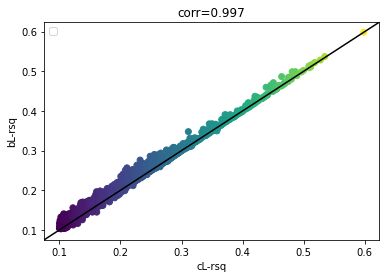

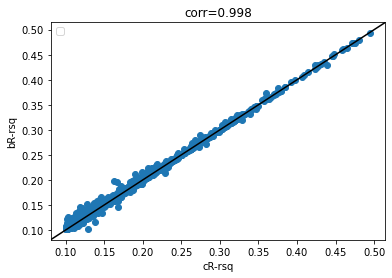

In [53]:
# check rsq
plt.figure()
dot_col = bprf_2E.prf_obj['cL'].pd_params.rsq.to_numpy()
bprf_2E.rapid_p_corr('cL-rsq', 'bL-rsq', do_id_line=True, pc='cL-rsq')
plt.figure()
bprf_2E.rapid_p_corr('cR-rsq', 'bR-rsq', do_id_line=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


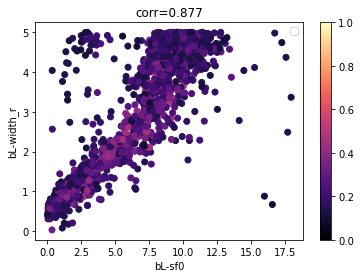

In [65]:
# check rsq
plt.figure()

bprf_2E.rapid_p_corr('bL-sf0', 'bL-width_r', do_id_line=False, pc='bL-rsq', vmin=0, vmax=1, dot_cmap='magma')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


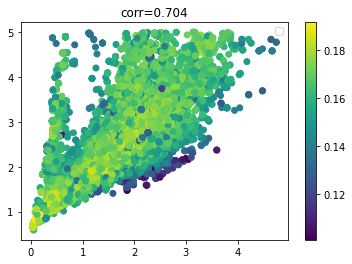

<Figure size 432x288 with 0 Axes>

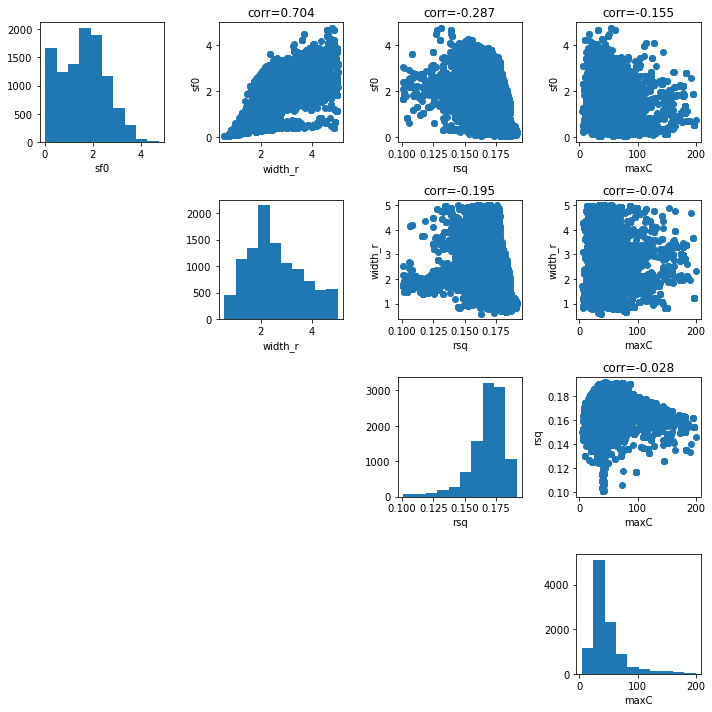

In [73]:
ivx_bprf = Prf1T1M(bprf_flat['R'][0], 'csf')
ivx_bprf.rapid_p_corr('sf0', 'width_r', pc='rsq')
plt.figure()
dag_multi_scatter(
    ivx_bprf.pd_params, p_labels=['sf0', 'width_r', 'rsq', 'maxC']
)
plt.gcf().set_size_inches(10,10)

In [ ]:
ivx = 1
burn_in = 0
ivx = 1
plt.plot(samples_pvx[1]['chain'][burn_in:,:,0])
# plt.plot(samples_pvx[ivx]['log_prob'])

plt.figure()
ivx = 5
plt.plot(samples_pvx[ivx]['chain'][burn_in:, :,0])

# Plot bayes fit vs classic fit, per voxel

      parameter,    classic, bayes-best,   bayes-Q1,   bayes-Q2,   bayes-Q3
________________________________________________________________________________
        width_r,      1.102,      1.017,      1.830,      2.382,      3.309
            sf0,      0.316,      0.234,      0.822,      1.669,      2.279
           maxC,     52.632,     43.669,     33.251,     40.745,     52.570
        width_l,      0.448,      0.448,      0.448,      0.448,      0.448
          amp_1,      1.841,      1.999,      1.442,      1.649,      1.912
  bold_baseline,      0.654,      0.680,      0.570,      0.641,      0.703
      hrf_deriv,      1.000,      1.000,      1.000,      1.000,      1.000
       hrf_disp,      0.000,      0.000,      0.000,      0.000,      0.000
            rsq,      0.192,      0.191,      0.163,      0.171,      0.177
B rsq = 0.191
C rsq = 0.192
(10349, 8)


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/model.py:986: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/model.py:986: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':


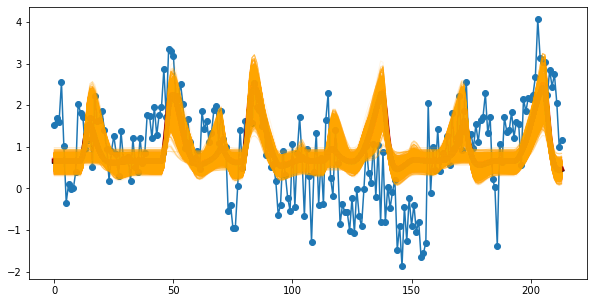

In [51]:
def plot_ts_bayes_vs_classic(ivx, real_tc, cprf_obj, bprf_obj, bprf_mcmc, bprf):
    '''
    plot_ts_bayes_vs_classic

    ivx         index of vx to plot
    real_tc     n_vx x timepts (real time course)
    cprf_obj    Prf1T1M object, with classical fit
    bprf_obj    Prf1T1M object, with bayesian fit
    bprf_mcmc   List (n_vx) of dictionaries, with 'chain', 'log_prob', 'rsq'. For each vx (MCMC posterior) 
    bprf        BayesPrf fitting object
    '''
    # Print relevant information
    print(f'{"parameter":>15}, {"classic":>10}, {"bayes-best":>10}, {"bayes-Q1":>10}, {"bayes-Q2":>10}, {"bayes-Q3":>10}')
    print("_"*80)
    for p in cprf_obj.model_labels:
        c_p = cprf_obj.pd_params[p][ivx]
        b_best_p = bprf_obj.pd_params[p][ivx]
        b_Q1_p = bprf_obj.pd_params[f'{p}_25'][ivx]
        b_Q2_p = bprf_obj.pd_params[f'{p}_50'][ivx]
        b_Q3_p = bprf_obj.pd_params[f'{p}_75'][ivx]
        this_str  = f'{p:>15}, '
        this_str += f'{c_p:>10.3f}, '
        this_str += f'{b_best_p:>10.3f}, '
        this_str += f'{b_Q1_p:>10.3f}, '
        this_str += f'{b_Q2_p:>10.3f}, '
        this_str += f'{b_Q3_p:>10.3f}'
        print(this_str)

    # Plot the true and estimated responses at different time points
    n_time_points = real_tc.shape[-1]
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(n_time_points), real_tc[ivx,:], 'o-', label='Data')
    bprf_ts = np.squeeze(bprf.prfpy_model.return_prediction(*list(bprf_obj.prf_params_np[ivx,:-1])))
    cprf_ts = np.squeeze(bprf.prfpy_model.return_prediction(*list(cprf_obj.prf_params_np[ivx,:-1])))
    print(f'B rsq = {dag_get_rsq(real_tc[ivx,:], bprf_ts):.3f}')
    print(f'C rsq = {dag_get_rsq(real_tc[ivx,:], cprf_ts):.3f}')
    plt.plot(np.arange(n_time_points), cprf_ts, 'k-', label='C', lw=5)
    plt.plot(np.arange(n_time_points), bprf_ts, 'r-', label='BB', lw=5, alpha=0.6)
    # random selection of mcmc...
    n_mcmc = bprf_mcmc[ivx].shape[0]
    mcmc_list = np.random.choice(n_mcmc, n_mcmc, replace=False) # plot 
    print(bprf_mcmc[ivx][mcmc_list,:-1].shape)
    this_ts = bprf.prfpy_model.return_prediction(*list(bprf_mcmc[ivx][mcmc_list,:-1].T))
    plt.plot(np.arange(n_time_points), this_ts.T, color='orange', alpha=0.1, lw=1)
    return


ivx = 0
eye='R'
vx_mask = amb_load_roi(sub, 'V1_exvivo')
plot_ts_bayes_vs_classic(
    ivx=ivx, 
    real_tc=real_tc[f'CSF{eye}E'][vx_mask,:], 
    cprf_obj=cprf_obj[eye], 
    bprf_obj=bprf_obj[eye], 
    bprf_mcmc=bprf_flat[eye],
    bprf=bprf,
    )

In [48]:
bprf_flat['L'][0].shape

(3264, 9)

array([0, 1, 2])